In [4]:
# import libraries 

from sklearn.datasets import load_files       
from sklearn.metrics import confusion_matrix 

from glob import glob

from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image 

from PIL import Image

import seaborn as sns
import numpy as np

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline


from tqdm import tqdm

Using TensorFlow backend.


In [5]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[35:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

#np.load('test_targets.csv')

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


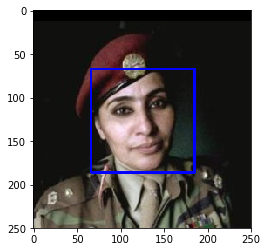

In [7]:
import cv2                  
import matplotlib.pyplot as plt                      
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 100.0% faces are detected in human files
- 11.0% faces are detected in dog files

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
from tqdm import tqdm

def file_detection(files_path):

    count = 0 
    files_total = len(files_path)
    
    for img_path in files_path:
        count +=face_detector(img_path)
    return count, files_total

count, files_total = file_detection(human_files_short)
print("{}% faces are detected in human files".format((count/files_total)*100))

count, files_total = file_detection(dog_files_short)
print("{}% faces are detected in dog files".format((count/files_total)*100))

100.0% faces are detected in human files
11.0% faces are detected in dog files


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [10]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [11]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [1]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/envs/python36/lib/python3.6

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [13]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- 0.0%  are detected as dogs in human files
- 100.0%  are detected as dogs dog files

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_detector_test(files):
    count = 0;
    total_count = len(files)
    for img_path in files:
        count += dog_detector(img_path)
    return count, total_count

In [13]:
count, total_count = dog_detector_test(human_files_short)

print("{}%  are detected as dogs in human files".format((count/total_count)*100))

count, total_count = dog_detector_test(dog_files_short)
print("{}%  are detected as dogs dog files".format((count/total_count)*100))

0.0%  are detected as dogs in human files
100.0%  are detected as dogs dog files


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 6680/6680 [01:30<00:00, 73.69it/s] 


In [ ]:
#from numpy import genfromtxt

#test_targets = genfromtxt('test_targets.csv', delimiter=',')
#train_targets = genfromtxt('train_targets.csv', delimiter=',')
#valid_targets = genfromtxt('valid_targets.csv', delimiter=',')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
- 1st layer: Conv2D with a 5, 5 kernel size and 16 filters padding is set 'same' to guarantee the input and output size is the same. 
- 2nd layer: Max pooling is used to reduce the spatial dimensions.
- 3rd layer: Another Cond2D layer with increased filtersize.
- 4th layer: Max pooling is used to reduce the spatial dimensions.
- 5th layer: Another Cond2D layer with increased filtersize.
- 6th layer: Max pooling is used to reduce the spatial dimensions.
- 7th layer: Flatten the data to one dimension.
- 8th layer: Added a Dense layer with activation 'relu'. Due to the fact that relu not activate all neurons at the same time it can help us to detect patterns in our dataset. 
- 9th layer: Drop out to minimize overfitting.
- 10th layer: Last layer is a Dense layer with activation 'softmax' and the same dimensions as the dog classes.

In [116]:
### TODO: Define your architecture.
#from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
#from keras.layers import Dropout, Flatten, Dense
#from keras.models import Sequential

### TODO: Define your architecture.



model = Sequential([
Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)),
MaxPooling2D(pool_size=2),
Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
MaxPooling2D(pool_size=2),
Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'),
MaxPooling2D(pool_size=2),
Flatten(),
Dense(256, activation='relu'),
Dropout(0.5),
Dense(133, activation='softmax'),
])



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      12832     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
__________

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist_testmodel = model.fit(train_tensors, train_targets, 
                 validation_data=(valid_tensors, valid_targets),
                 epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
#define plot for visualistion of the loss between test and train/validation datasets

def plotloss(mdl):
    loss = mdl.history['loss']
    val_loss = mdl.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='blue', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Valid/Test'], loc='upper left')
    plt.show()

#define plot for visualistion of accuracy between test and train/validation datasets    
    
def plotaccuracy(mdl):
    acc = mdl.history['acc']
    val_acc = mdl.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='blue', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend(['Train', 'Valid/Test'], loc='upper left')
    plt.show()

In [ ]:
#execution of plots
plotloss(hist_testmodel)
plotaccuracy(hist_testmodel)

In [ ]:
#Define confusion matirix

from sklearn.metrics import confusion_matrix 
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(12,10))
matrix = confusion_matrix([np.argmax(x) for x in test_targets], dog_breed_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(matrix);
plt.title('Confusion Matrix', fontsize=15);
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Correct', fontsize=15)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [47]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [48]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

hist_VGG16 = VGG16_model.fit(train_VGG16, train_targets, 
             validation_data=(valid_VGG16, valid_targets),
             epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [64]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.7943%


### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [ ]:
plotloss(hist_VGG16)
plotaccuracy(hist_VGG16)

In [82]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

def conf_matrix(Prediction):
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    matrix = confusion_matrix([np.argmax(x) for x in test_targets], Prediction)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matrix);
    plt.title('Confusion Matrix', fontsize=15);
    plt.xlabel('Prediction', fontsize=15)
    plt.ylabel('Correct', fontsize=15)

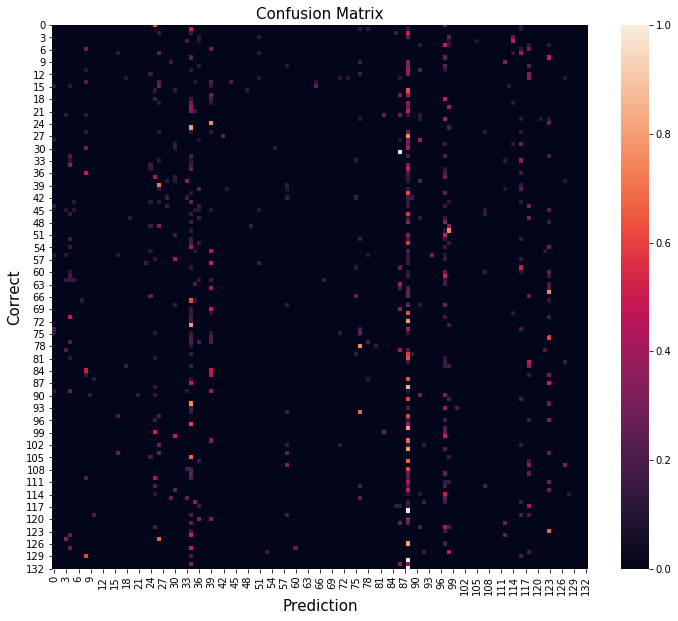

In [83]:
cm(VGG16_predictions)

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [237]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

import time

# define testing fuction for the networks

def trans_net_test(network):
    
    # bottleneck features
    print('...loading bottleneck features...')
    bottleneck_features = np.load('bottleneck_features/Dog{}Data.npz'.format(network))
    
    # transfer bottleneck into train, test and validation 
    train_bottle = bottleneck_features['train']
    test_bottle = bottleneck_features['test']
    valid_bottle = bottleneck_features['valid']
    
    # model architecture
    print('...loading model architecture...')
    trans_model = Sequential()
    trans_model.add(GlobalAveragePooling2D(input_shape=train_bottle.shape[1:]))
    trans_model.add(Dense(133, activation='softmax'))
    
    # model compiling
    print('...compiling...')
    trans_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    #train model
    print('...train model with {}...'.format(network))
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}.hdf5'.format(network), 
                                   verbose=1, save_best_only=True)

    
    hist_model = trans_model.fit(train_bottle, train_targets,
                 validation_data=(valid_bottle, valid_targets),
                 epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)
  


    #load best model
    print('...loading best model...')
    trans_model.load_weights('saved_models/weights.best.{}.hdf5'.format(network))
    
    # testing the model
    print('...testing model...')
    trans_predictions = [np.argmax(trans_model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottle]
    
    #  test accuracy
    test_accuracy = 100*np.sum(np.array(trans_predictions)==np.argmax(test_targets, axis=1))/len(trans_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
 
    #define plot for visualistion of the loss between test and train/validation datasets
 
    #def plotloss(mdl):
    loss = hist_model.history['loss']
    val_loss = hist_model.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='blue', label='Validation loss')
    plt.title('Training and validation loss for {}'.format(network))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Valid/Test'], loc='upper left')
    plt.show()

    #plotloss(hist_model)   
    
#define plot for visualistion of accuracy between test and train/validation datasets    
    
    #def plotaccuracy(mdl):
    acc = hist_model.history['acc']
    val_acc = hist_model.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='blue', label='Validation acc')
    plt.title('Training and validation accuracy for {}'.format(network))
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend(['Train', 'Valid/Test'], loc='upper left')
    plt.show()



    
    return print('Test accuracy for {}: %.4f%%'.format(network) % test_accuracy)
 
    
   


 

...loading bottleneck features...
...loading model architecture...
...compiling...
...train model with VGG16...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 5s - loss: 11.7224 - acc: 0.1344 - val_loss: 10.1678 - val_acc: 0.2228

Epoch 00001: val_loss improved from inf to 10.16777, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
 - 1s - loss: 9.2215 - acc: 0.3139 - val_loss: 9.2817 - val_acc: 0.2946

Epoch 00002: val_loss improved from 10.16777 to 9.28170, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
 - 1s - loss: 8.5074 - acc: 0.3885 - val_loss: 8.8266 - val_acc: 0.3341

Epoch 00003: val_loss improved from 9.28170 to 8.82663, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
 - 1s - loss: 8.0627 - acc: 0.4301 - val_loss: 8.3809 - val_acc: 0.3665

Epoch 00004: val_loss improved from 8.82663 to 8.38087, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/20
 - 1s - loss: 7.7902 - acc: 0.4674 - val_loss: 8.1888 - va

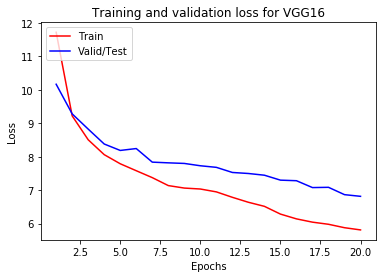

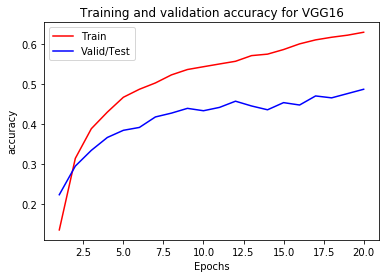

Test accuracy for VGG16: 49.6411%
...loading bottleneck features...
...loading model architecture...
...compiling...
...train model with VGG19...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 5s - loss: 11.5087 - acc: 0.1507 - val_loss: 9.9626 - val_acc: 0.2419

Epoch 00001: val_loss improved from inf to 9.96261, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/20
 - 1s - loss: 9.0650 - acc: 0.3274 - val_loss: 9.1170 - val_acc: 0.3210

Epoch 00002: val_loss improved from 9.96261 to 9.11704, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 3/20
 - 1s - loss: 8.3310 - acc: 0.4069 - val_loss: 8.6389 - val_acc: 0.3569

Epoch 00003: val_loss improved from 9.11704 to 8.63894, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 4/20
 - 1s - loss: 8.0245 - acc: 0.4478 - val_loss: 8.5164 - val_acc: 0.3725

Epoch 00004: val_loss improved from 8.63894 to 8.51639, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 5/20
 - 1s - loss: 7.8148 - acc:

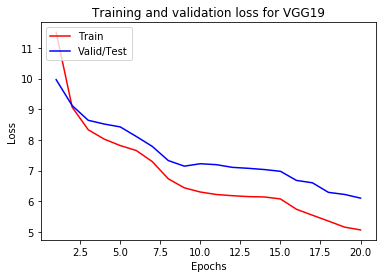

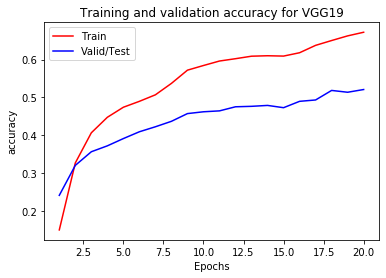

Test accuracy for VGG19: 52.5120%
...loading bottleneck features...
...loading model architecture...
...compiling...
...train model with InceptionV3...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 5s - loss: 1.1513 - acc: 0.7088 - val_loss: 0.7208 - val_acc: 0.7940

Epoch 00001: val_loss improved from inf to 0.72084, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/20
 - 1s - loss: 0.4747 - acc: 0.8519 - val_loss: 0.6986 - val_acc: 0.8132

Epoch 00002: val_loss improved from 0.72084 to 0.69860, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 3/20
 - 1s - loss: 0.3677 - acc: 0.8910 - val_loss: 0.6632 - val_acc: 0.8443

Epoch 00003: val_loss improved from 0.69860 to 0.66320, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 4/20
 - 1s - loss: 0.2937 - acc: 0.9097 - val_loss: 0.7232 - val_acc: 0.8359

Epoch 00004: val_loss did not improve from 0.66320
Epoch 5/20
 - 1s - loss: 0.2376 - acc: 0.9266 - val_loss: 0.6904 - val_ac

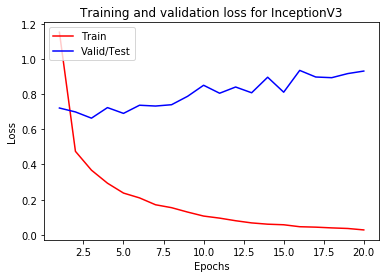

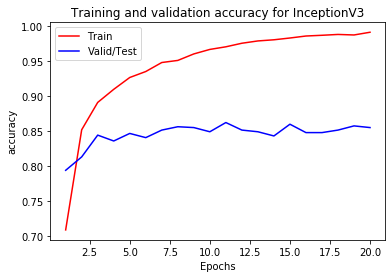

Test accuracy for InceptionV3: 77.9904%
...loading bottleneck features...
...loading model architecture...
...compiling...
...train model with Xception...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 6s - loss: 1.0530 - acc: 0.7350 - val_loss: 0.5275 - val_acc: 0.8251

Epoch 00001: val_loss improved from inf to 0.52752, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/20
 - 2s - loss: 0.3979 - acc: 0.8737 - val_loss: 0.5088 - val_acc: 0.8371

Epoch 00002: val_loss improved from 0.52752 to 0.50878, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/20
 - 2s - loss: 0.3262 - acc: 0.8978 - val_loss: 0.4938 - val_acc: 0.8443

Epoch 00003: val_loss improved from 0.50878 to 0.49383, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/20
 - 2s - loss: 0.2840 - acc: 0.9108 - val_loss: 0.5174 - val_acc: 0.8455

Epoch 00004: val_loss did not improve from 0.49383
Epoch 5/20
 - 2s - loss: 0.2467 - acc: 0.9223 - val_loss: 0.5031 - val_acc: 0.8

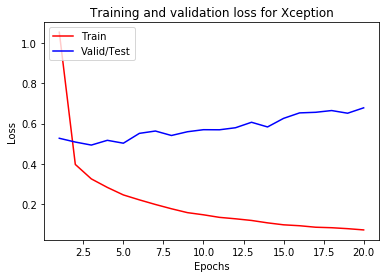

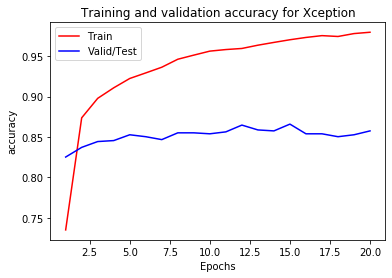

Test accuracy for Xception: 83.8517%
...loading bottleneck features...
...loading model architecture...
...compiling...
...train model with Resnet50...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 5s - loss: 1.6363 - acc: 0.5967 - val_loss: 0.7878 - val_acc: 0.7557

Epoch 00001: val_loss improved from inf to 0.78775, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/20
 - 1s - loss: 0.4378 - acc: 0.8599 - val_loss: 0.6984 - val_acc: 0.7868

Epoch 00002: val_loss improved from 0.78775 to 0.69841, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 3/20
 - 1s - loss: 0.2637 - acc: 0.9193 - val_loss: 0.7454 - val_acc: 0.7940

Epoch 00003: val_loss did not improve from 0.69841
Epoch 4/20
 - 1s - loss: 0.1815 - acc: 0.9455 - val_loss: 0.6653 - val_acc: 0.7952

Epoch 00004: val_loss improved from 0.69841 to 0.66531, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 5/20
 - 1s - loss: 0.1252 - acc: 0.9609 - val_loss: 0.6672 - val_acc: 0.8084

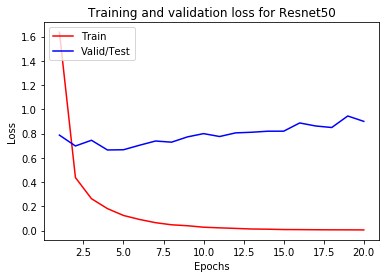

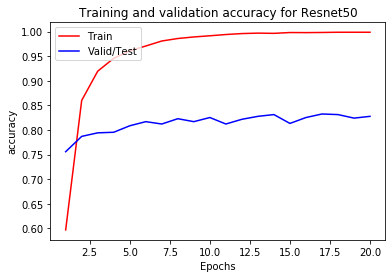

Test accuracy for Resnet50: 79.9043%


In [238]:
#networks = ['VGG16','VGG19','InceptionV3', 'Xception','Resnet50']

#for network in networks:
#    net_acc = trans_net_test(network)

In [1]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/envs/python36/lib/python3.6

In [51]:
# wurde fürs interne juphyter gebraucht

#from numpy import genfromtxt

#test_targets = genfromtxt('test_targets.csv', delimiter=',')
#train_targets = genfromtxt('train_targets.csv', delimiter=',')
#valid_targets = genfromtxt('valid_targets.csv', delimiter=',')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
After testing the networks, I decided to use transfer learning and use Resnet 50. While Xeption supplies a slightly better test accuracy the size of the bottleneck features is too unwieldy for me. ResNet as a pre-trained network delivers a similarly good performance with almost 80% test accuracy. 

I have also added a fully connected dense layer with activation relu and a dropout to reduce overfitting. 



In [16]:
# loading bottleneck
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [119]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(256, activation='relu'))
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [120]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [121]:
### TODO: Train the model.


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

hist_RES= Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 31s 5ms/step - loss: 3.1356 - acc: 0.2907 - val_loss: 1.1976 - val_acc: 0.6814
Epoch 2/100
6680/6680 [==============================] - 10s 1ms/step - loss: 1.4239 - acc: 0.5892 - val_loss: 0.8149 - val_acc: 0.7605
Epoch 3/100
6680/6680 [==============================] - 10s 1ms/step - loss: 1.0382 - acc: 0.6889 - val_loss: 0.6765 - val_acc: 0.7749
Epoch 4/100
6680/6680 [==============================] - 10s 1ms/step - loss: 0.8563 - acc: 0.7310 - val_loss: 0.6398 - val_acc: 0.7904
Epoch 5/100
6680/6680 [==============================] - 9s 1ms/step - loss: 0.7387 - acc: 0.7635 - val_loss: 0.6351 - val_acc: 0.8084
Epoch 6/100
6680/6680 [==============================] - 10s 1ms/step - loss: 0.6344 - acc: 0.7919 - val_loss: 0.6019 - val_acc: 0.8144
Epoch 7/100
6680/6680 [==============================] - 10s 1ms/step - loss: 0.6123 - acc: 0.7967 - val_loss: 0.5976 - val_acc: 0.8240
Ep

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [122]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [123]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]



test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.0239%


Text(87,0.5,'Correct')

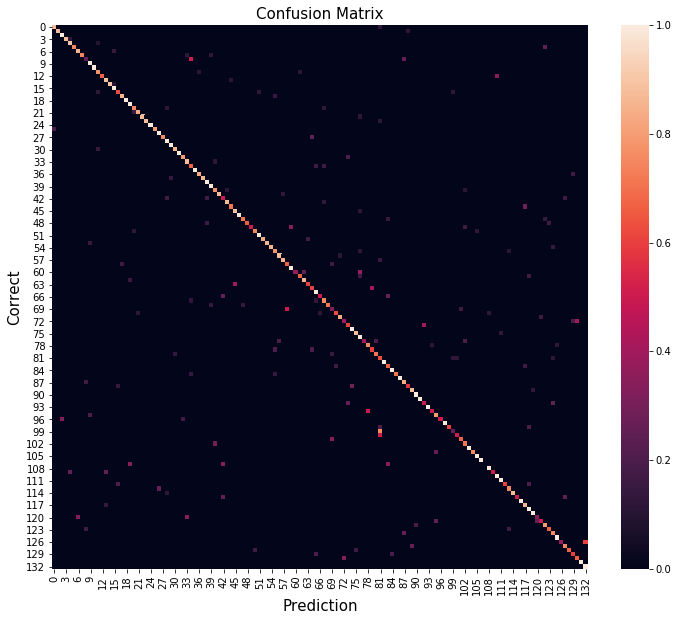

In [124]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(12,10))
matrix = confusion_matrix([np.argmax(x) for x in test_targets], Resnet50_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(matrix);
plt.title('Confusion Matrix', fontsize=15);
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Correct', fontsize=15)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [125]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import * 

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    #add because of error
    #print(bottleneck_feature.shape)
    #bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    #bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    #bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    #print(bottleneck_feature.shape)
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [126]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_breed_prediction(img_path):
    
# show image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
# human or dog detector
    human = face_detector(img_path)
    dog = dog_detector(img_path)

# if clause for dog breed detection
    if dog:
        breed = Resnet50_predict_breed(img_path)
        print ("This is a dog and it's breed is {}.".format(breed))
    elif human:
        breed = Resnet50_predict_breed(img_path)
        print("This is not a dog but it's look like a {}.".format(breed))
    else:
        print("This looks niether human or dog, must be something else.")   

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

From my point of view it works very well, the algorithm only has its difficulties with similar breeds. These could be remedied with the following adjustments.

Architecture:

- Increase the model capacitiy by adding more layers
- change the batchsize or change the learing rate 
- increase the number of epochs

Redesign the image: 
- change the resolution 
- rotation or flipping the image
- random image shifts



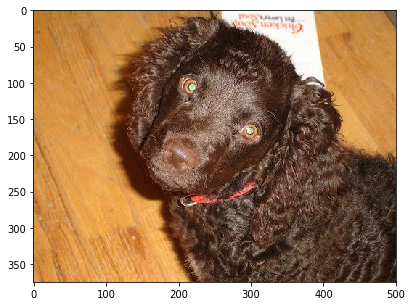

This is a dog and it's breed is American_water_spaniel.


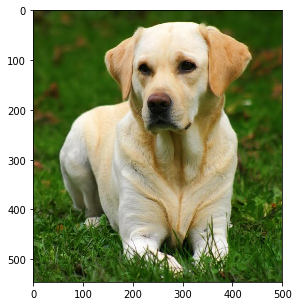

This is a dog and it's breed is Labrador_retriever.


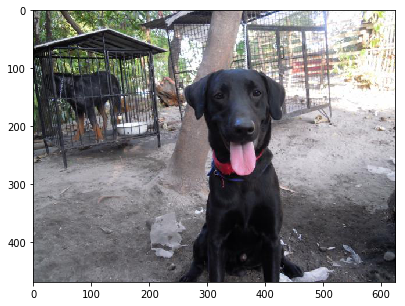

This is a dog and it's breed is Flat-coated_retriever.


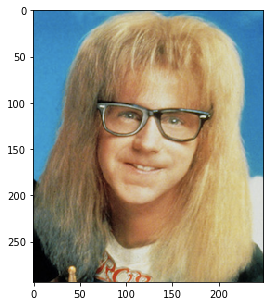

This is not a dog but it's look like a Cocker_spaniel.


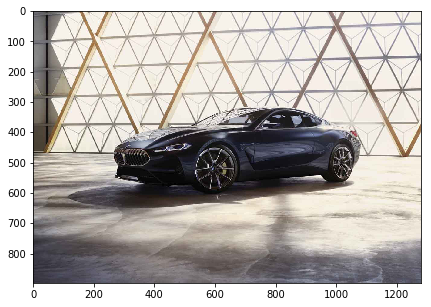

This looks niether human or dog, must be something else.


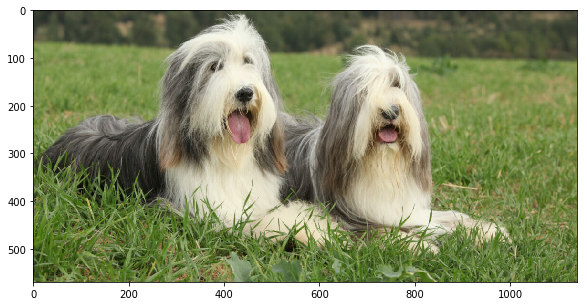

This is a dog and it's breed is Bearded_collie.


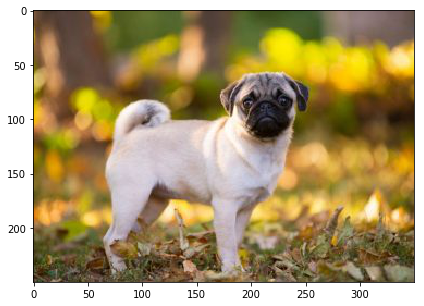

This is a dog and it's breed is Mastiff.


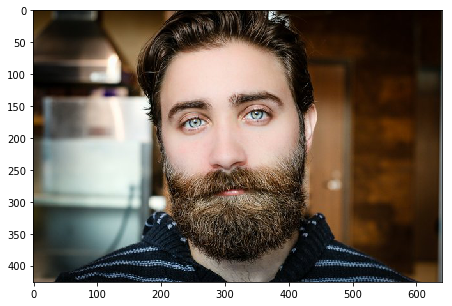

This is not a dog but it's look like a Cocker_spaniel.


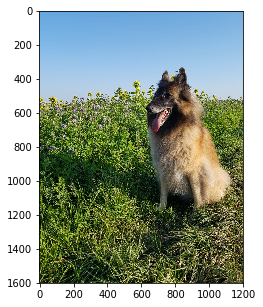

This is a dog and it's breed is Keeshond.


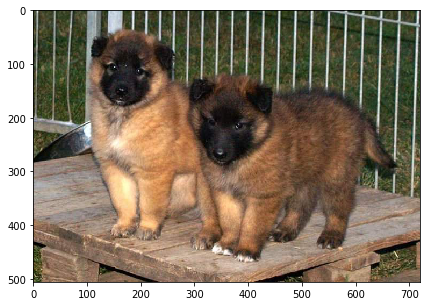

This is a dog and it's breed is Belgian_tervuren.


In [127]:
# dog
dog_breed_prediction("images/American_water_spaniel_00648.jpg")
# dog
dog_breed_prediction("images/Labrador_retriever_06457.jpg")
# dog
dog_breed_prediction("images/Labrador_retriever_06449.jpg")
# human
dog_breed_prediction("images/sample_human_2.png")
# car
dog_breed_prediction("images/A0238540.JPG")
#dog
dog_breed_prediction("images/bearded-collie-zu-zweit-1140x570.jpg")
#dog
dog_breed_prediction("images/mops-draussen.1-350x250.jpg")
#human
dog_breed_prediction("images/beard-1845166_1920.jpg")
#dog 
dog_breed_prediction("images/8.jpg")
#puppy
dog_breed_prediction("images/9.jpg")